In [4]:
import sys
from pathlib import Path

from tqdm import tqdm
import toml

import numpy as np

import torch
from torch.utils.data import DataLoader
import torch.optim as optim

from utils import threshold, criterion, norm, unnorm
from dataset_utils import create_dataset,imagenet_loader
from models import load_model
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image
# Configure Script
config = toml.load('configs/imagenet/whitebox/imagebind.toml')['general']

gpu_num = config['gpu_num']
epochs = config['epochs']
batch_size = config['batch_size']
eps = config['epsilon']
zero_shot_steps = config['zero_shot_steps']
lr = config['lr']
eta_min = config['eta_min']
seed = config['seed']
output_dir = config['output_dir']
n_images = config['number_images']
buffer_size = config['buffer_size']
delta = config['delta']
model_flag = config.get('model_flag', 'imagebind')
embs_input = config.get('embeddings_input', output_dir + 'embs.npy')\
                   .format(model_flag)
gamma_epochs = config.get('gamma_epochs', 100)
modality = config.get('modality', 'vision')
dataset_flag = config.get('dataset_flag', 'imagenet')

if modality == 'vision':
    eps = eps / 255

if type(epochs) == list:
    max_epochs = max(epochs)
else:
    max_epochs = epochs
    epochs = [epochs]

Path(output_dir).mkdir(parents=True, exist_ok=True)

device = f"cuda:{gpu_num}" if torch.cuda.is_available() and gpu_num >= 0 else "cpu"
assert n_images % batch_size == 0

# Instantiate Model
model = load_model(model_flag, device)

In [6]:
X_path = 'data/thermal/001.jpg'
X=imagenet_loader(X_path,model, device)
X_init = X.clone().detach().cpu().requires_grad_(False)
target_text=["murderer with gun",]
Y = model.forward(target_text, "text", normalize=False)
X, Y = X.to(device).requires_grad_(True), Y.to(device)

In [5]:
max_epochs=2000
pbar = tqdm(range(max_epochs))
X_init = X.clone().detach().cpu().requires_grad_(False)
X, Y= X.to(device).requires_grad_(True), Y.to(device)
X_max, X_min = threshold(X, eps, modality, device)
optimizer = optim.SGD([X], lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                            np.arange(gamma_epochs, max_epochs, gamma_epochs),
                                            gamma=0.9)
for j in pbar:
    eta = scheduler.get_last_lr()[0]
    embeds = model.forward(X, modality, normalize=False)
    cton = 1 - criterion(embeds, Y, dim=1).detach().cpu()
    loss = 1 - criterion(embeds, Y, dim=1)
    update = eta * torch.autograd.grad(outputs=loss.mean(), inputs=X)[0].sign()
    X = (X.detach().cpu() - update.detach().cpu()).to(device)
    X = torch.clamp(X, min=X_min, max=X_max).requires_grad_(True)
    pbar.set_postfix({'loss': cton, 'eta': eta})
    scheduler.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

NameError: name 'X' is not defined

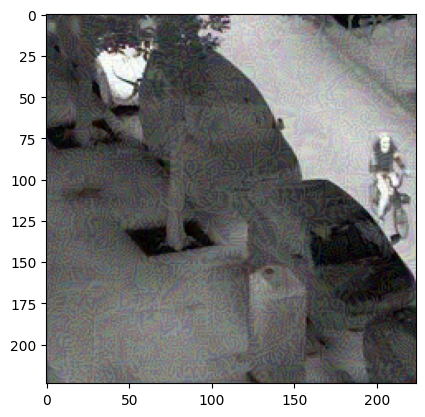

In [25]:
transform = transforms.ToPILImage()
plt.imshow(transform(unnorm(torch.squeeze(X))[0]))
plt.show()

In [26]:
save_image(unnorm(torch.squeeze(X.cuda()))[0], 'data/thermal_perturbed/001.png')

In [10]:
#load every image in the folder and perturb it, and save to the perturbed folder
import os

# Define the paths for the original and perturbed folders
original_folder = 'data/thermal'
perturbed_folder = 'data/thermal_perturbed'

# Get the list of image files in the original folder
image_files = [file for file in os.listdir(original_folder) if file.endswith('.jpg') ]

# Iterate over each image file
for image_file in image_files:
    # Load the original image
    perturbed_image_path = os.path.join(original_folder, image_file)
    X=imagenet_loader(perturbed_image_path,model, device)
    X_init = X.clone().detach().cpu().requires_grad_(False)
    target_text=["murderer with gun",]
    Y = model.forward(target_text, "text", normalize=False)
    X, Y = X.to(device).requires_grad_(True), Y.to(device)

    max_epochs=2000
    pbar = tqdm(range(max_epochs))
    X_init = X.clone().detach().cpu().requires_grad_(False)
    X, Y= X.to(device).requires_grad_(True), Y.to(device)
    X_max, X_min = threshold(X, eps, modality, device)
    optimizer = optim.SGD([X], lr=lr)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                np.arange(gamma_epochs, max_epochs, gamma_epochs),
                                                gamma=0.9)
    for j in pbar:
        eta = scheduler.get_last_lr()[0]
        embeds = model.forward(X, modality, normalize=False)
        cton = 1 - criterion(embeds, Y, dim=1).detach().cpu()
        loss = 1 - criterion(embeds, Y, dim=1)
        update = eta * torch.autograd.grad(outputs=loss.mean(), inputs=X)[0].sign()
        X = (X.detach().cpu() - update.detach().cpu()).to(device)
        X = torch.clamp(X, min=X_min, max=X_max).requires_grad_(True)
        pbar.set_postfix({'loss': cton, 'eta': eta})
        scheduler.step()

    perturbed_image_path = os.path.join(perturbed_folder, image_file)
    save_image(unnorm(torch.squeeze(X.cuda()))[0], perturbed_image_path)

print("Perturbation completed and images saved to the perturbed folder.")


  0%|          | 0/2000 [00:00<?, ?it/s, loss=tensor([0.8330]), eta=0.02]/home/tz362/anaconda3/envs/pandagpt/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
 37%|███▋      | 744/2000 [00:51<01:26, 14.58it/s, loss=tensor([0.1591]), eta=0.0162]